In [1]:
from math import sqrt

import numpy as np
import scipy.optimize
import quadpy

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
from nanoscale_test import fieldplot2

In [3]:
import scattnlay
from scattnlay import fieldnlay
from scattnlay import scattnlay

In [4]:
WL=455 #nm 				# wave length
core_r = 90.0			# partical radius

x = np.ones((1), dtype = np.float64)
x[0] = core_r

npts = 151					# plot will be npts x npts
factor=1.1					# area of plot

index = 4.6265+0.13845j	# refractive index
nm = 1.0						# refractive index of host media

m = np.ones((1), dtype = np.complex128)
m[0] = index/nm

In [5]:
scan = np.linspace(-factor*x[-1], factor*x[-1], npts)
zero = np.zeros(npts*npts, dtype = np.float64)

coordX, coordZ = np.meshgrid(scan, scan)
coordX.resize(npts * npts)
coordZ.resize(npts * npts)
coordY = zero

normalize_units = np.vectorize(lambda t: 1.0*t/WL*2.0*np.pi)

coord = np.vstack((coordX, coordY, coordZ)).transpose()
_, E, _ = fieldnlay(np.array([normalize_units(x)]), np.array([m]), normalize_units(coord), pl=-1)
Ec = E[0, :, :]
#Hc = H[0, :, :]
#P = np.array(map(lambda n: np.linalg.norm(np.cross(Ec[n], Hc[n])).real, range(0, len(E[0]))))

CPU times: user 197 ms, sys: 175 ms, total: 372 ms
Wall time: 478 ms


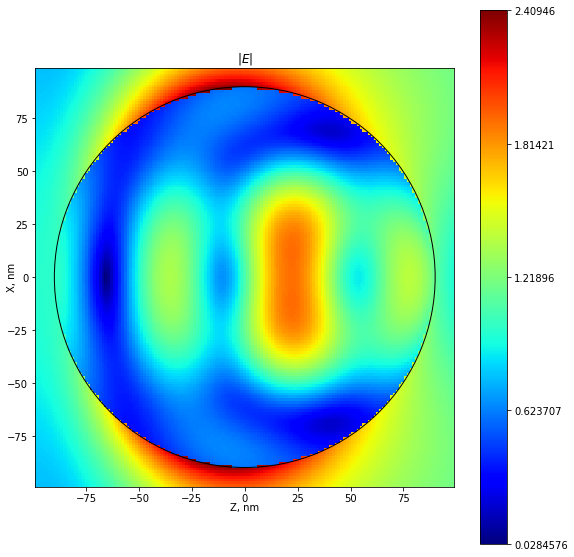

In [6]:
%%time

flow_total = 0

Er = np.absolute(Ec)
Eabs = np.sqrt(Er[:, 0]**2 + Er[:, 1]**2 + Er[:, 2]**2)
#Eabs = Er[:, 1]

fieldplot2(flow_total, Eabs, coordX, coordZ, x, m, npts, factor)

In [7]:
normalized_r = normalize_units(core_r).reshape(1)[0]
normalized_x = normalize_units(x)

In [8]:
from math import sqrt, cos, sin, acos
import quadpy

EPS = 1e-8

def _rotate(m, v):
	return np.array(m).dot(np.array(v))

def rotateAroundX(v, angle):
	return _rotate(
		[[1, 0, 0],
		[0, cos(angle), sin(angle)],
		[0, -sin(angle), cos(angle)]], v)

def rotateAroundY(v, angle):
	return _rotate(
		[[cos(angle), 0, -sin(angle)],
		[0, 1, 0],
		[sin(angle), 0, cos(angle)]], v)

def rotateAroundZ(v, angle):
	return _rotate(
		[[cos(angle), sin(angle), 0],
		[-sin(angle), cos(angle), 0],
		[0, 0, 1]], v)

# oriented angle from a to b
def angle2D(ax, ay, bx, by):
	a = np.array([ax, ay, 0])
	b = np.array([bx, by, 0])
	a = a / np.linalg.norm(a)
	b = b / np.linalg.norm(b)

	angle = acos(a.dot(b))
	cross = np.cross(a, b)
	if np.array([0, 0, 1]).dot(cross) < 0:
		angle = -angle

	return angle

def directiveGain(vr, radius):
	# TODO: divide by smth
    
	#if abs(vr[0]) > EPS:
	#	pol = np.array([-vr[2] / vr[0], 0, 1])
	#elif abs(vr[2]) > EPS:
	#	pol = np.array([1, 0, -vr[0] / vr[2]])
	#else:
	#	pol = np.array([-1, 0, 0])
	b = np.array([0, 0, normalize_units(radius)])
	#print "before", vr, "pol", pol, "b", b
    
	if abs(vr[0]) > EPS or abs(vr[2]) > EPS:
		angle = angle2D(vr[0], vr[2], 0, 1)
		vr = rotateAroundY(vr, angle)
	#	pol = rotateAroundY(pol, angle)
		b = rotateAroundY(b, angle)
		#print "after0", vr, "angle", angle, "pol", pol

	if abs(vr[1]) > EPS or abs(vr[2]) > EPS:
		angle = angle2D(vr[1], vr[2], 0, 1)
		vr = rotateAroundX(vr, angle)
	#	pol = rotateAroundX(pol, angle)
		b = rotateAroundX(b, angle)
		#print "after1", vr, "angle", angle, "pol", pol

	#assert abs(pol[0]) > EPS or abs(pol[1]) > EPS
	#angle = angle2D(pol[0], pol[1], 1, 0)
	#vr = rotateAroundZ(vr, angle)
	#pol = rotateAroundZ(pol, angle)
	#b = rotateAroundZ(b, angle)
	#print "after", vr, "b", b, "pol", pol

	_, E, H = fieldnlay(np.array([normalized_x]), np.array([m]), b.reshape(1, 3), pl=-1)

	assert E.shape == (1, 1, 3)
	vx, vy, vz = np.real(E[0][0])
	bx, by, bz = b

	px = by * vz - bz * vy
	py = - bx * vz + bz * vx
	pz = bx * vy - by * vx

	#print px, py, pz, bx, by, bz
	#print px * px + py * py + pz * pz, bx * bx + by * by + bz * bz
    
	res = sqrt((px * px + py * py + pz * pz) / (bx * bx + by * by + bz * bz))
    
	if res > 1500:
		print "res", res, "vr", vr, "radius", radius
		print "p", px, py, pz
		print "b", bx, by, bz
		print "v", vx, vy, vz
    
	return res

def integrate(radius, normalized_r, normalized_x):
	val = quadpy.sphere.integrate(
	    lambda xs: np.apply_along_axis(lambda t: directiveGain(t, radius), 0, xs),
	    [0.0, 0.0, 0.0], 1.0,
	    quadpy.sphere.Lebedev("19"))

	return val

In [9]:
res = np.apply_along_axis(lambda t: directiveGain(t /np.linalg.norm(t), np.linalg.norm(t)), 1, coord)
res = res.reshape((npts, npts))

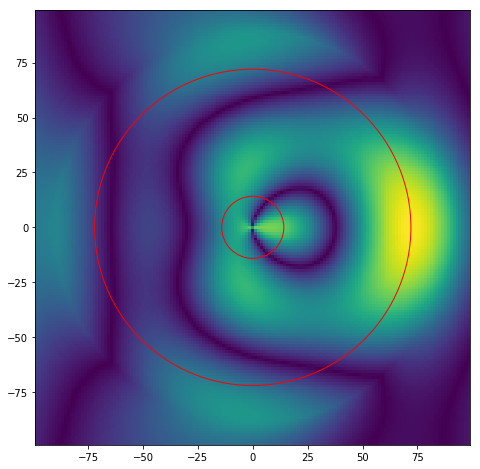

In [47]:
min_tick = np.amin(coord)
max_tick = np.amax(coord)

plt.figure(figsize=(16,8))
_ = plt.imshow(res.T, origin='lower', extent=[min_tick,max_tick,min_tick,max_tick])

fig = plt.gcf()
ax = fig.gca()
_ = ax.add_patch(Circle((0, 0), 14.14, fill=False, color='r'))
_ = ax.add_patch(Circle((0, 0), 72, fill=False, color='r'))

In [49]:
find_max2(72)

1.1592969772306105

In [48]:
find_max2(14.14)

0.8900489376149863

In [17]:
def find_max3(radius):
    p = np.array([0, 0, 1])
    res2 = directiveGain(p, radius)
    #print(res2)
    return np.max(res2)

In [18]:
def find_max2(radius):
    xs = quadpy.sphere.Lebedev("19").points
    res = np.apply_along_axis(lambda t: directiveGain(t, radius), 1, xs)
    #print "xs", xs
    #print "res", res
    return np.max(res)

In [19]:
def find_max(radius):
    result = scipy.optimize.minimize(
        lambda x: -directiveGain(x, radius),
        np.array([0, 0, radius]), 
        method='SLSQP',
        options={'disp': True},
        constraints={'type': 'eq', "fun": lambda xs: np.linalg.norm(xs) - radius})

In [20]:
print find_max3(50), find_max2(50), find_max(50)
print find_max3(22), find_max2(22), find_max(22)

0.5977320239110934 0.5977320239110934Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.597732023911
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
 None
0.6912784066781086 0.8003878992492687Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.691278406678
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
 None


In [63]:
#xs = np.linspace(min(coordX), max(coordX))
xs = np.linspace(0.001, max(coordX))
ints = np.vectorize(lambda t: integrate(t, normalized_r, normalized_x))(xs)

In [ ]:
np.seterr(all='raise')

In [62]:
#maxs = np.vectorize(lambda t: find_max2(normalize_units(t).reshape(1)[0]))(xs)
maxs = np.zeros(len(xs))
for i in range(len(xs)):
    #maxs[i] = find_max2(xs[i])
    maxs[i] = find_max2(xs[i])

In [58]:
print maxs
#maxs[0] = maxs[1]

[0.8698048  0.87021693 0.87063831 0.87105826 0.87147677 0.87189384
 0.87230947 0.87272366 0.8731364  0.8735477  0.87395756 0.87436596
 0.87477292 0.87517842 0.87558248 0.87598507 0.87638622 0.87678591
 0.87718413 0.8775809  0.87797621 0.87837006 0.87876244 0.87915336
 0.87954281 0.87993079 0.8803173  0.88070234 0.88108591 0.881468
 0.88184862 0.88222776 0.88260542 0.88298161 0.88335631 0.88372953
 0.88410127 0.88447152 0.88484028 0.88520756 0.88557335 0.88593764
 0.88630045 0.88666176 0.88702158 0.88737989 0.88773672 0.88809204
 0.88844586 0.88879818]


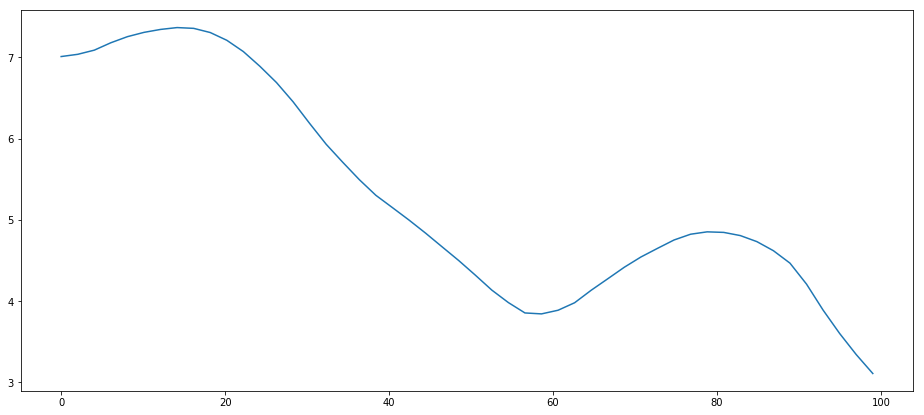

In [64]:
plt.figure(figsize=(16, 7))
#_ = plt.plot(xs, maxs)
_ = plt.plot(xs, ints)

Maximum is at radius 72.73495918367348


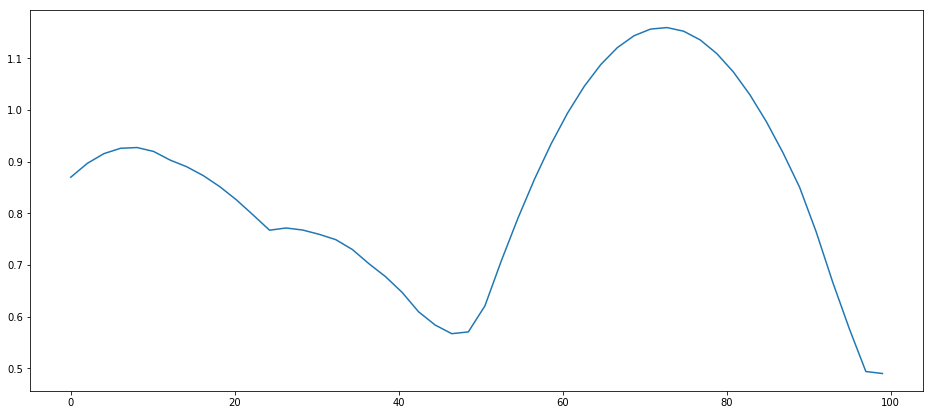

In [67]:
plt.figure(figsize=(16, 7))
_ = plt.plot(xs, maxs)
maxrad = xs[np.argmax(maxs)]
print "Maximum is at radius", maxrad
#_ = plt.axvline(x=maxrad)

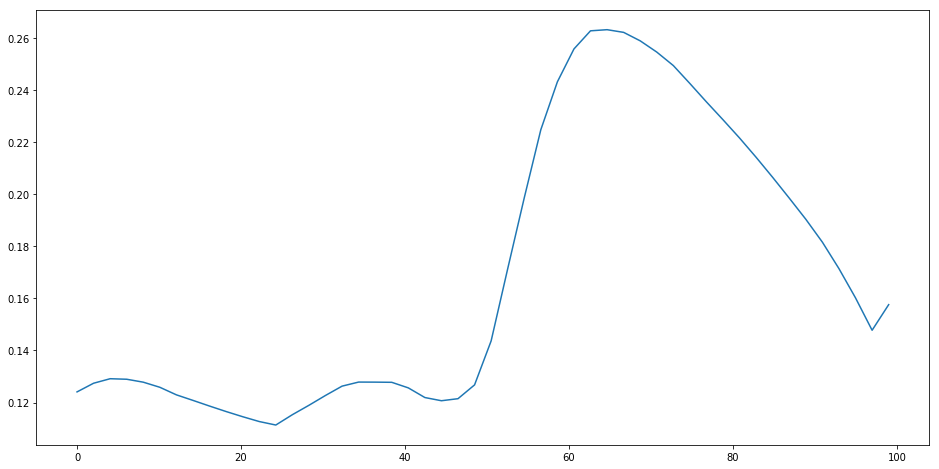

In [68]:
plt.figure(figsize=(16,8))
_ = plt.plot(xs, maxs / ints)